In [2]:
import ot
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy
from sklearn.base import clone
import seaborn as sns
from tqdm import tqdm_notebook

import sklearn
from sklearn.preprocessing import LabelBinarizer, LabelEncoder, StandardScaler

### Generate the problem / prepare selected datasets

In [3]:
nrows = None

In [4]:
numerical_features_index = [0, 2, 4, 10, 11, 12]

data_train = pd.read_csv('../datasets/Adult income dataset/adult.data', nrows=nrows, header=None)
y_train = data_train.loc[:, data_train.columns[-1]]
gender_train = data_train.loc[:, data_train.columns[9]]


data_test = pd.read_csv('../datasets/Adult income dataset/adult.test', skiprows=1, header=None)
y_test = data_test.loc[:, data_train.columns[-1]]
gender_test = data_test.loc[:, data_test.columns[9]]

data_train.drop(data_train.columns.difference(numerical_features_index), axis=1, inplace=True)
data_test.drop(data_test.columns.difference(numerical_features_index), axis=1, inplace=True)
data_train = data_train.astype(np.float64)
data_test = data_test.astype(np.float64)


gender_train = gender_train.apply(lambda x: x.strip())
gender_test = gender_test.apply(lambda x: x.strip())

In [5]:
data_train.shape

(32561, 6)

In [6]:
data_train.drop_duplicates(inplace=True)
y_train = y_train.loc[data_train.index]
gender_train = gender_train.loc[data_train.index]

assert data_train.shape[0] == y_train.shape[0] == gender_train.shape[0]

In [7]:
binarizer = LabelBinarizer()
y_train = binarizer.fit_transform(y_train).ravel()
y_test = binarizer.fit_transform(y_test).ravel()

In [8]:
gender_binarizer = LabelBinarizer()
gender_binary = gender_binarizer.fit_transform(gender_test.values).ravel()

In [9]:
scaler = StandardScaler()
data_train = scaler.fit_transform(data_train)
data_test = scaler.transform(data_test)

In [18]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from collections import Counter

In [11]:
random_seed=777 #tri topora

In [12]:
clf_base = LogisticRegression(random_state=random_seed)

In [16]:
clf = clone(clf_base)

clf.fit(data_train, y_train)

clf_predictions = clf.predict(data_test)

In [19]:
Counter(clf_predictions)

Counter({0: 14123, 1: 2158})

In [14]:
print('Initial accuracy of classification: {}'.format(accuracy_score(y_test, clf.predict(data_test))))

Initial accuracy of classification: 0.8134021251765862


In [15]:
male_entries_index = gender_train[gender_train == 'Male'].index
female_entries_index = gender_train[gender_train == 'Female'].index

male_entries_test_index = gender_test[gender_test == 'Male'].index
female_entries_test_index = gender_test[gender_test == 'Female'].index

In [22]:
n0 = data_train[gender_train == 'Male'].shape[0]
n1 = data_train[gender_train == 'Female'].shape[0]
n0_test = data_test[gender_test == 'Male'].shape[0]
n1_test = data_test[gender_test == 'Female'].shape[0]

emperical_histogram_male = np.ones_like(male_entries_index) / n0
emperical_histogram_female = np.ones_like(female_entries_index) / n1

emperical_histogram_male_test = np.ones_like(male_entries_test_index) / n0_test
emperical_histogram_female_test = np.ones_like(female_entries_test_index) / n1_test

In [20]:
C = ot.dist(data_test[gender_test == 'Male'], data_test[gender_test == 'Female'])

In [17]:
def f(G):
    return 0.5 * np.sum(G**2)


def df(G):
    return G

In [23]:
# coupling1 = ot.optim.gcg(emperical_histogram_male, emperical_histogram_female, C, reg1=1e-3, reg2=1e-1, f=f, df=df, numItermax=100000000, verbose=True)
%time
coupling1 = ot.stochastic.solve_semi_dual_entropic(emperical_histogram_male_test, emperical_histogram_female_test, C, reg=1, method='SAG', numItermax=100000, log=True)[0]

CPU times: user 4 µs, sys: 3 µs, total: 7 µs
Wall time: 12.9 µs


In [24]:
%%time
coupling = ot.emd(emperical_histogram_male_test, emperical_histogram_female_test, C, numItermax=1000000000)

CPU times: user 30.2 s, sys: 719 ms, total: 30.9 s
Wall time: 30.7 s


In [30]:
num = 100

In [25]:
y_first = clf_predictions[gender_test == 'Male']
y_second = clf_predictions[gender_test == 'Female']
print('class 0 size {}'.format(y_first.shape))
print('class 1 size {}'.format(y_second.shape))

class 0 size (10860,)
class 1 size (5421,)


In [27]:
from mapper import full_repair, partial_repair, random_repair
from utils import balanced_error_rate, disparate_impact, likelihood_ratio

In [28]:
def subsample_maps(num_samples, num_couplings, data_first, data_second, y_first, y_second, coupling_function):
    assert num_samples < min(len(data_first, data_second))
    index_1 = np.random.choice(np.arange(0, len(data_first)), size=num_samples, replace=False)
    index_2 = np.random.choice(np.arange(0, len(data_second)), size=num_samples, replace=False)
    couplings = []
    for coupling_index in range(num_couplings):
        coupling = coupling_function(data_first[index_1], data_second[index_2], y_first[index_1], y_second[index_2])
        couplings.append(coupling)
    return couplings

In [35]:
acs = []
dims = []

for repair_value in tqdm_notebook(np.linspace(0, 1, num=num)):
    X_new, y_new = partial_repair(repair_value, data_test[gender_test == 'Male'], data_test[gender_test == 'Female'], coupling, y_first, y_second)
    #clf1 = clone(clf_base)
    #clf1.fit(X_new, y_new)
    accuracy_sc = accuracy_score(y_test, clf.predict(X_new))
    disparate_im = disparate_impact(clf.predict(X_new), gender_binary)
    acs.append(accuracy_sc)
    dims.append(disparate_im)

In [40]:
acs_1 = []
dims_1 = []

for repair_value in tqdm_notebook(np.linspace(0, 1, num=num)):
    X_new, y_new = partial_repair(repair_value, data_test[gender_test == 'Male'], data_test[gender_test == 'Female'], coupling1, y_first, y_second)
#     clf1 = clone(clf_base)
#     clf1.fit(X_new, y_new)
    accuracy_sc = accuracy_score(y_test, clf.predict(X_new))
    disparate_im = disparate_impact(clf.predict(X_new), gender_binary)
    acs_1.append(accuracy_sc)
    dims_1.append(disparate_im)

In [42]:
acs_2 = []
dims_2 = []

for repair_value in tqdm_notebook(np.linspace(0, 1, num=num)):
    X_new, y_new = random_repair(repair_value, 0.5, data_test[gender_test == 'Male'], data_test[gender_test == 'Female'], coupling, y_first, y_second)
#     clf1 = clone(clf_base)
#     clf1.fit(X_new, y_new)
    accuracy_sc = accuracy_score(y_test, clf.predict(X_new))
    disparate_im = disparate_impact(clf.predict(X_new), gender_binary)
    acs_2.append(accuracy_sc)
    dims_2.append(disparate_im)

In [43]:
acs_3 = []
dims_3 = []

for repair_value in tqdm_notebook(np.linspace(0, 1, num=num)):
    X_new, y_new = random_repair(repair_value, 0.5, data_test[gender_test == 'Male'], data_test[gender_test == 'Female'], coupling1, y_first, y_second)
#     clf1 = clone(clf_base)
#     clf1.fit(X_new, y_new)
    accuracy_sc = accuracy_score(y_test, clf.predict(X_new))
    disparate_im = disparate_impact(clf.predict(X_new), gender_binary)
    acs_3.append(accuracy_sc)
    dims_3.append(disparate_im)

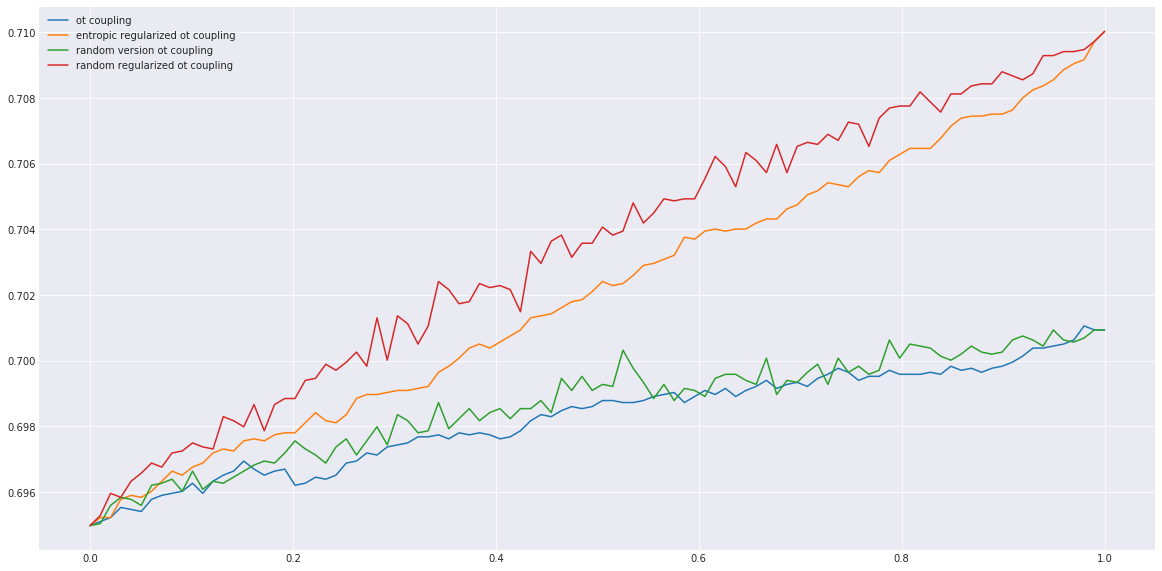

In [44]:
with sns.axes_style('darkgrid'):
    plt.figure(figsize=(20, 10))
    plt.plot(np.linspace(0, 1, num), acs, label='ot coupling')
    plt.plot(np.linspace(0, 1, num), acs_1, label='entropic regularized ot coupling')
    plt.plot(np.linspace(0, 1, num), acs_2, label='random version ot coupling')
    plt.plot(np.linspace(0, 1, num), acs_3, label='random regularized ot coupling')
    plt.legend()

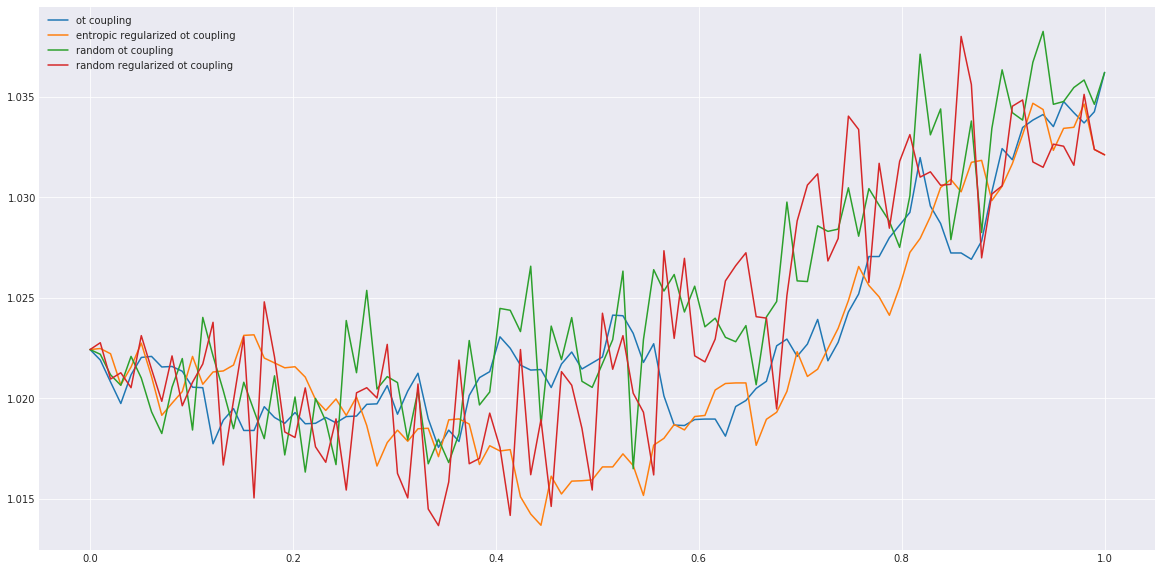

In [45]:
with sns.axes_style('darkgrid'):
    plt.figure(figsize=(20, 10))
    plt.plot(np.linspace(0, 1, num), dims, label='ot coupling')
    plt.plot(np.linspace(0, 1, num), dims_1, label='entropic regularized ot coupling')
    plt.plot(np.linspace(0, 1, num), dims_2, label='random ot coupling')
    plt.plot(np.linspace(0, 1, num), dims_3, label='random regularized ot coupling')
    plt.legend()
    plt.show()

### Show that different solutions for the same transporation problem can have different target metric value

### Explore how the regularized barycenters are defined, try to apply them to the problem

### Use the regularized transport maps instead of usual ones